In [39]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [41]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [42]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [43]:
tf.keras.backend.clear_session()

In [44]:
subject = 'Sergipe - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [45]:
data = pd.read_csv('2003_mo_model_input_SE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Consumo de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego
0,2003-1,0.669217,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,23.616,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,8.389943
1,2003-2,0.669542,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,21.357,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,8.384067
2,2003-3,0.669868,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,20.059,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,8.378190
3,2003-4,0.670193,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,19.920,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,8.372313
4,2003-5,0.670519,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,19.962,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,8.366437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.559734,1016.393425,1805.116974,26.507012,18.430052,62.341257,2.358476,0.557749,169.752591,34.037,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.608339,1015.080131,1574.401843,26.322413,18.203643,63.309790,2.528498,0.556659,169.621865,32.537,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.751674,1014.417552,1588.495720,26.332336,18.354571,64.284429,2.639647,0.555237,169.855545,35.215,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.448162,1013.842001,1596.409135,26.280254,18.100840,64.131495,2.703013,0.553445,170.188727,34.707,NaN,NaN,NaN,NaN,NaN


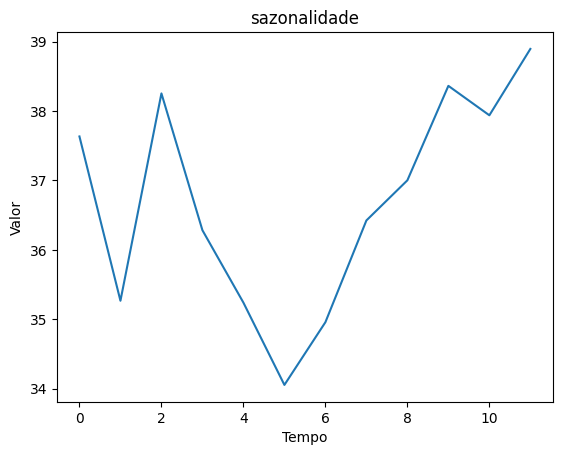

,sazonalidade
sazonalidade,
0,37.634714
1,35.266071
2,38.255214
3,36.282786
4,35.238857
5,34.052571
6,34.956615
7,36.423692
8,37.002462


In [46]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [47]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego,sazonalidade,Sergipe - Consumo de Cimento (t)
0,2003-1,0.669217,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,8.389943,37.634714,23.616
1,2003-2,0.669542,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,8.384067,35.266071,21.357
2,2003-3,0.669868,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,8.378190,38.255214,20.059
3,2003-4,0.670193,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,8.372313,36.282786,19.920
4,2003-5,0.670519,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,8.366437,35.238857,19.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.559734,1016.393425,1805.116974,26.507012,18.430052,62.341257,2.358476,0.557749,169.752591,NaN,NaN,NaN,NaN,NaN,36.423692,34.037
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.608339,1015.080131,1574.401843,26.322413,18.203643,63.309790,2.528498,0.556659,169.621865,NaN,NaN,NaN,NaN,NaN,37.002462,32.537
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.751674,1014.417552,1588.495720,26.332336,18.354571,64.284429,2.639647,0.555237,169.855545,NaN,NaN,NaN,NaN,NaN,38.364231,35.215
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.448162,1013.842001,1596.409135,26.280254,18.100840,64.131495,2.703013,0.553445,170.188727,NaN,NaN,NaN,NaN,NaN,37.939846,34.707


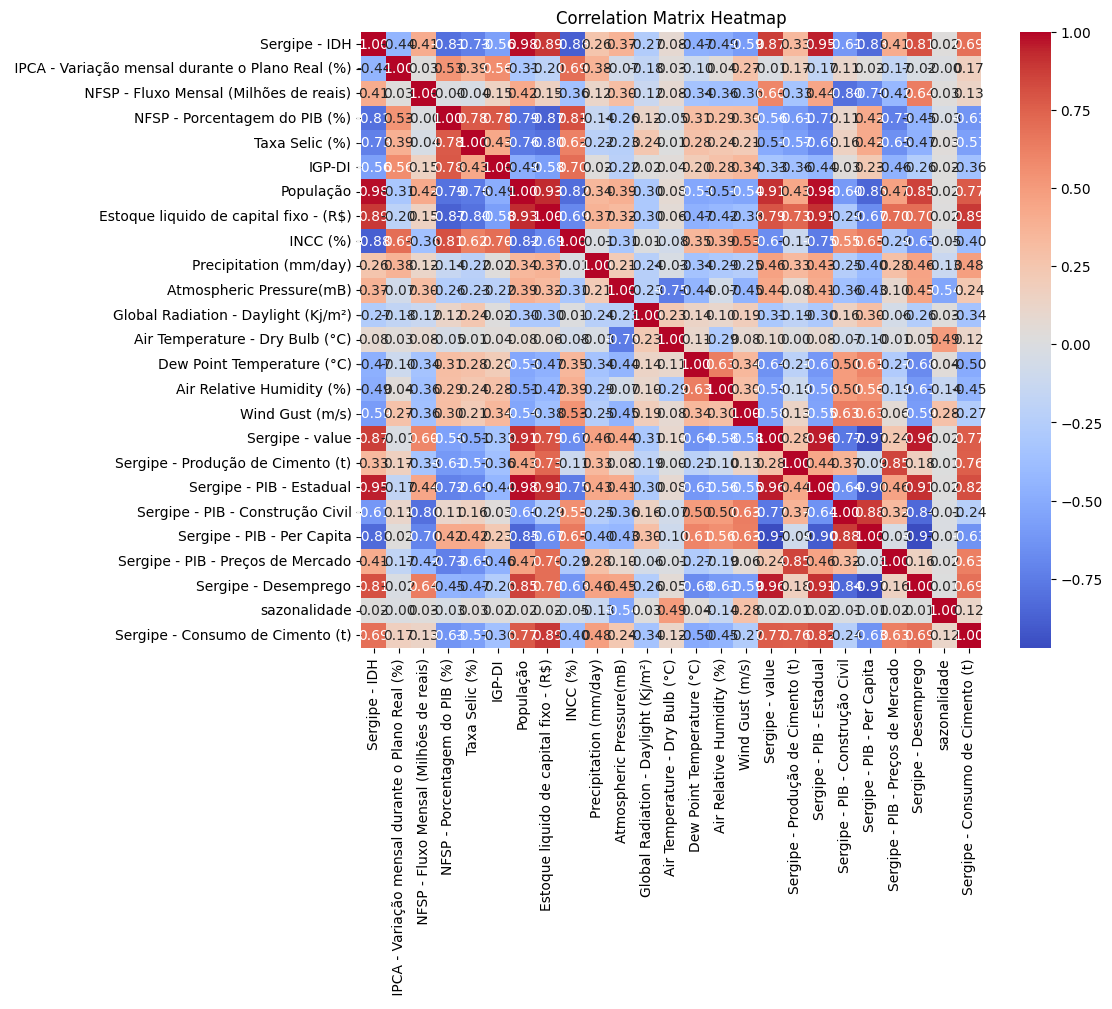

In [48]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [49]:
data =data.drop(['Air Temperature - Dry Bulb (°C)'], axis=1)
data

,Unnamed: 0,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego,sazonalidade,Sergipe - Consumo de Cimento (t)
0,2003-1,0.669217,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,1.154340,1013.090299,2716.496979,23.889841,80.366597,3.552746,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,8.389943,37.634714,23.616
1,2003-2,0.669542,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,1.155152,1013.092341,2716.496979,23.879336,80.334711,3.551254,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,8.384067,35.266071,21.357
2,2003-3,0.669868,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.155625,1013.093533,2716.496979,23.873208,80.316112,3.550384,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,8.378190,38.255214,20.059
3,2003-4,0.670193,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.155676,1013.093660,2716.496979,23.872551,80.314119,3.550291,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,8.372313,36.282786,19.920
4,2003-5,0.670519,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.195157,1012.797543,2575.798720,23.787977,79.846291,3.554977,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,8.366437,35.238857,19.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.559734,1016.393425,1805.116974,18.430052,62.341257,2.358476,0.557749,169.752591,NaN,NaN,NaN,NaN,NaN,36.423692,34.037
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.608339,1015.080131,1574.401843,18.203643,63.309790,2.528498,0.556659,169.621865,NaN,NaN,NaN,NaN,NaN,37.002462,32.537
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.751674,1014.417552,1588.495720,18.354571,64.284429,2.639647,0.555237,169.855545,NaN,NaN,NaN,NaN,NaN,38.364231,35.215
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.448162,1013.842001,1596.409135,18.100840,64.131495,2.703013,0.553445,170.188727,NaN,NaN,NaN,NaN,NaN,37.939846,34.707


In [50]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego,sazonalidade
0,-2.191597,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.548085,-0.493535,0.032132,1.048294,0.984037,0.681598,-1.329544,-1.638248,-1.769739,-0.221258,0.566843,-2.721827,-0.858763,0.627872
1,-2.153964,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.546183,-0.491902,0.032132,1.044155,0.980200,0.679921,-1.294452,-1.660220,-1.748579,-0.190897,0.585366,-2.626858,-0.861105,-0.951067
2,-2.116331,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.545073,-0.490950,0.032132,1.041741,0.977962,0.678942,-1.260345,-1.593729,-1.727419,-0.160535,0.603889,-2.531890,-0.863447,1.041498
3,-2.078698,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.544954,-0.490848,0.032132,1.041482,0.977722,0.678837,-1.227259,-1.555337,-1.706259,-0.130173,0.622411,-2.436921,-0.865789,-0.273324
4,-2.041065,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.452431,-0.727528,-0.000203,1.008162,0.921429,0.684109,-1.199102,-1.514074,-1.685099,-0.099812,0.640934,-2.341953,-0.868132,-0.969208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.375707,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-0.680585,1.085592,-0.271128,-0.787513,-0.794757,-0.158732,0.926582,-1.147300,1.088440,-1.830495,-1.273118,-0.375044,1.205390,-0.179396
188,1.367460,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-0.703466,0.572047,-0.255214,-0.689721,-0.831530,0.082503,0.922177,-1.137939,1.080037,-1.823605,-1.263526,-0.370593,1.201393,0.206412
189,1.359213,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,-0.740767,0.287615,-0.243580,-0.598683,-0.900168,0.139265,0.923529,-1.097718,1.071634,-1.816716,-1.253934,-0.366142,1.197396,1.114168
190,1.350966,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,-0.620199,-0.037242,-0.238785,-0.468197,-0.922448,0.139457,0.936477,-1.086004,1.063231,-1.809827,-1.244342,-0.361691,1.193399,0.831273


In [51]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      19.642
1      17.778
2      21.180
3      18.824
4      16.535
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Sergipe - Consumo de Cimento (t), Length: 240, dtype: float64

In [52]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego,sazonalidade
0,-2.191597,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.548085,-0.493535,0.032132,1.048294,0.984037,0.681598,-1.329544,-1.638248,-1.769739,-0.221258,0.566843,-2.721827,-0.858763,0.627872
1,-2.153964,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.546183,-0.491902,0.032132,1.044155,0.980200,0.679921,-1.294452,-1.660220,-1.748579,-0.190897,0.585366,-2.626858,-0.861105,-0.951067
2,-2.116331,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.545073,-0.490950,0.032132,1.041741,0.977962,0.678942,-1.260345,-1.593729,-1.727419,-0.160535,0.603889,-2.531890,-0.863447,1.041498
3,-2.078698,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.544954,-0.490848,0.032132,1.041482,0.977722,0.678837,-1.227259,-1.555337,-1.706259,-0.130173,0.622411,-2.436921,-0.865789,-0.273324
4,-2.041065,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.452431,-0.727528,-0.000203,1.008162,0.921429,0.684109,-1.199102,-1.514074,-1.685099,-0.099812,0.640934,-2.341953,-0.868132,-0.969208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.387754,-0.214006,1.216560,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,0.009032,0.045232,-0.261620,-0.383585,-0.969536,-0.200945,1.521513,-0.132792,1.143453,-1.270245,-1.549275,-0.543399,1.342411,-0.951067
158,1.390522,-0.434717,1.155373,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,0.129672,0.442509,-0.284364,-0.409807,-0.892104,-0.757620,1.498482,-0.189562,1.147046,-1.306762,-1.539477,-0.525912,1.335629,1.041498
159,1.393291,-0.524091,1.056140,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,0.203960,0.938373,-0.300292,-0.549218,-0.868043,-1.333123,1.475235,-0.253067,1.150639,-1.343278,-1.529680,-0.508425,1.328848,-0.273324
160,1.396059,-0.614500,1.147619,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,0.503234,1.548347,-0.308038,-0.700311,-0.824927,-1.951565,1.452580,-0.330172,1.154232,-1.379795,-1.519882,-0.490938,1.322066,-0.969208


In [53]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.642
1      17.778
2      21.180
3      18.824
4      16.535
        ...  
157    37.579
158    48.016
159    38.263
160    40.413
161    34.053
Name: Sergipe - Consumo de Cimento (t), Length: 162, dtype: float64

In [54]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [55]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 23)

In [56]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego,sazonalidade
126,0.374606,0.888984,-0.230612,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,1.895509,1.315363,-0.300921,-0.242958,0.188587,-0.456712,0.708889,1.481103,0.853614,-0.111030,-0.618059,1.032015,0.905037,-1.157350
127,0.381094,0.954254,-0.156322,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,1.706520,0.984885,-0.285073,-0.170554,0.209644,-0.050220,0.753914,1.474131,0.869229,-0.156897,-0.659078,0.974979,0.923945,-0.179396
128,0.387582,1.045217,-0.120008,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,3.153518,0.487571,-0.264858,0.090714,0.358234,0.391473,0.799633,1.440003,0.884845,-0.202764,-0.700096,0.917944,0.942853,0.206412
129,0.394069,1.176395,-0.143194,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,3.157052,0.061679,-0.252216,0.159843,0.366846,0.553913,0.849863,1.408120,0.900461,-0.248632,-0.741114,0.860908,0.961762,1.114168
130,0.400557,1.303259,-0.028712,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,2.755431,-0.414626,-0.245228,0.329438,0.484169,0.600096,0.896706,1.375556,0.916077,-0.294499,-0.782133,0.803873,0.980670,0.831273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.375707,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-0.680585,1.085592,-0.271128,-0.787513,-0.794757,-0.158732,0.926582,-1.147300,1.088440,-1.830495,-1.273118,-0.375044,1.205390,-0.179396
188,1.367460,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-0.703466,0.572047,-0.255214,-0.689721,-0.831530,0.082503,0.922177,-1.137939,1.080037,-1.823605,-1.263526,-0.370593,1.201393,0.206412
189,1.359213,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,-0.740767,0.287615,-0.243580,-0.598683,-0.900168,0.139265,0.923529,-1.097718,1.071634,-1.816716,-1.253934,-0.366142,1.197396,1.114168
190,1.350966,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,-0.620199,-0.037242,-0.238785,-0.468197,-0.922448,0.139457,0.936477,-1.086004,1.063231,-1.809827,-1.244342,-0.361691,1.193399,0.831273


In [57]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 23)

In [58]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [59]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [60]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [61]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2352129079, 156722747, 3894230208, 2361668245, 1151239993, 1287410369, 1972188675, 1117697676, 4188467205, 558355450, 597339281, 542176529, 2236826259, 717944672, 3157965619, 3927351035, 2543473211, 1268838447, 2380583144, 1071692251, 2569612648, 1096395070, 1800375028, 2622291970, 792173637, 3614435319, 2871070781, 1955212608, 1189436742, 3654225604, 1033339175, 643924814, 29898261, 3346885190, 1366352818, 3049435920, 1731696246, 2480162676, 893142124, 1111765716, 31993099, 3516032516, 1972298560, 1857899017, 3848756616, 759408438, 1746304634, 2791998373, 944325606, 1497339023]


Step: 0 ___________________________________________
val_loss: 8.156825065612793
winner_seed: 2352129079


Step: 1 ___________________________________________
val_loss: 8.526690483093262


Step: 2 ___________________________________________
val_loss: 8.32913875579834


Step: 3 ___________________________________________
val_loss: 9.4334716796875


Step: 4 ___________________________________________
val_loss: 

In [62]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 109ms/step - loss: 1611.6158 - val_loss: 100.8199
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 98.2296 - val_loss: 168.0436
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 116.7348 - val_loss: 95.5087
Epoch 4/10000
4/4 [==============================] - 0s 8ms/step - loss: 63.9741 - val_loss: 67.4947
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 41.6605 - val_loss: 69.4832
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 697.3867 - val_loss: 1094.8989
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 453.5920 - val_loss: 42.4043
Epoch 8/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.1699 - val_loss: 42.9655
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 31.5458 - val_loss: 64.3365
Epoch 10/10000
4/4 [==============================] - 0s 8ms/step - loss: 71.947

4/4 [==============================] - 0s 8ms/step - loss: 8.9824 - val_loss: 28.3435
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.9154 - val_loss: 14.9012
Epoch 83/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.0786 - val_loss: 17.0192
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.8301 - val_loss: 21.5110
Epoch 85/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.6356 - val_loss: 18.4627
Epoch 86/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.6502 - val_loss: 18.7888
Epoch 87/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.3186 - val_loss: 16.2042
Epoch 88/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.2896 - val_loss: 18.3802
Epoch 89/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.8656 - val_loss: 15.0354
Epoch 90/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.2456 - val_loss: 17.5419
Epoch

4/4 [==============================] - 0s 7ms/step - loss: 6.1219 - val_loss: 14.8001
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2300 - val_loss: 11.7406
Epoch 163/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.7322 - val_loss: 19.3601
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0887 - val_loss: 11.3311
Epoch 165/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9151 - val_loss: 14.8574
Epoch 166/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.5657 - val_loss: 12.7458
Epoch 167/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.1954 - val_loss: 22.9336
Epoch 168/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.8317 - val_loss: 13.1972
Epoch 169/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6495 - val_loss: 12.9915
Epoch 170/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.5944 - val_loss: 12.6

4/4 [==============================] - 0s 8ms/step - loss: 5.2864 - val_loss: 12.5031
Epoch 242/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0063 - val_loss: 11.1286
Epoch 243/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0056 - val_loss: 12.4290
Epoch 244/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0841 - val_loss: 14.4704
Epoch 245/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2826 - val_loss: 12.4303
Epoch 246/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7563 - val_loss: 11.5489
Epoch 247/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7011 - val_loss: 13.3130
Epoch 248/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2431 - val_loss: 12.8346
Epoch 249/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6599 - val_loss: 11.9819
Epoch 250/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6505 - val_loss: 11.7

4/4 [==============================] - 0s 7ms/step - loss: 4.8096 - val_loss: 14.3157
Epoch 322/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5158 - val_loss: 11.3227
Epoch 323/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6517 - val_loss: 12.1908
Epoch 324/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5122 - val_loss: 13.5224
Epoch 325/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5009 - val_loss: 12.5681
Epoch 326/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6299 - val_loss: 12.4166
Epoch 327/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.3658 - val_loss: 13.8511
Epoch 328/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3408 - val_loss: 12.5326
Epoch 329/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3591 - val_loss: 12.7320
Epoch 330/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8916 - val_loss: 12.6

4/4 [==============================] - 0s 7ms/step - loss: 4.9414 - val_loss: 11.8778
Epoch 402/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5264 - val_loss: 12.0530
Epoch 403/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7732 - val_loss: 14.8562
Epoch 404/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5784 - val_loss: 11.8863
Epoch 405/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6167 - val_loss: 12.5776
Epoch 406/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2365 - val_loss: 11.7581
Epoch 407/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2585 - val_loss: 12.1935
Epoch 408/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6203 - val_loss: 12.1374
Epoch 409/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3624 - val_loss: 12.2678
Epoch 410/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1866 - val_loss: 14.3

4/4 [==============================] - 0s 8ms/step - loss: 4.3965 - val_loss: 11.5335
Epoch 482/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7837 - val_loss: 11.7981
Epoch 483/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0201 - val_loss: 11.4440
Epoch 484/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8903 - val_loss: 11.6549
Epoch 485/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.4566 - val_loss: 11.7909
Epoch 486/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5485 - val_loss: 11.9848
Epoch 487/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6210 - val_loss: 12.7697
Epoch 488/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4799 - val_loss: 11.2646
Epoch 489/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1291 - val_loss: 14.2999
Epoch 490/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8904 - val_loss: 11.2

4/4 [==============================] - 0s 8ms/step - loss: 4.3917 - val_loss: 11.0204
Epoch 562/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1476 - val_loss: 11.0725
Epoch 563/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2453 - val_loss: 10.8497
Epoch 564/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5934 - val_loss: 11.5716
Epoch 565/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9606 - val_loss: 12.8425
Epoch 566/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0592 - val_loss: 10.8163
Epoch 567/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4476 - val_loss: 11.8550
Epoch 568/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3033 - val_loss: 11.4535
Epoch 569/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9989 - val_loss: 11.7799
Epoch 570/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2572 - val_loss: 11.6

4/4 [==============================] - 0s 7ms/step - loss: 3.9556 - val_loss: 11.6918
Epoch 642/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5019 - val_loss: 12.7156
Epoch 643/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2822 - val_loss: 11.3652
Epoch 644/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7772 - val_loss: 12.5649
Epoch 645/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8605 - val_loss: 11.2698
Epoch 646/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9213 - val_loss: 12.8270
Epoch 647/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5967 - val_loss: 13.0444
Epoch 648/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2405 - val_loss: 12.3137
Epoch 649/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3819 - val_loss: 11.7351
Epoch 650/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9588 - val_loss: 10.5

4/4 [==============================] - 0s 7ms/step - loss: 3.8312 - val_loss: 11.6121
Epoch 722/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0434 - val_loss: 10.6080
Epoch 723/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9947 - val_loss: 10.9222
Epoch 724/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0632 - val_loss: 12.6348
Epoch 725/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2294 - val_loss: 11.7297
Epoch 726/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7179 - val_loss: 11.2927
Epoch 727/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8878 - val_loss: 12.0414
Epoch 728/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3030 - val_loss: 11.6334
Epoch 729/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7674 - val_loss: 10.6214
Epoch 730/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8586 - val_loss: 11.2

4/4 [==============================] - 0s 7ms/step - loss: 3.8960 - val_loss: 10.9863
Epoch 802/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4409 - val_loss: 10.6818
Epoch 803/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4826 - val_loss: 10.3928
Epoch 804/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8335 - val_loss: 10.7110
Epoch 805/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2742 - val_loss: 10.5385
Epoch 806/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4778 - val_loss: 10.8750
Epoch 807/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6886 - val_loss: 11.1398
Epoch 808/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2218 - val_loss: 11.0768
Epoch 809/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5821 - val_loss: 12.4656
Epoch 810/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9232 - val_loss: 11.3

4/4 [==============================] - 0s 7ms/step - loss: 3.6278 - val_loss: 10.2837
Epoch 882/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9661 - val_loss: 10.1592
Epoch 883/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7542 - val_loss: 10.7122
Epoch 884/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6625 - val_loss: 12.0343
Epoch 885/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0517 - val_loss: 10.8902
Epoch 886/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7208 - val_loss: 10.3090
Epoch 887/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5904 - val_loss: 10.4511
Epoch 888/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3423 - val_loss: 9.3045
Epoch 889/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3747 - val_loss: 10.0606
Epoch 890/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6603 - val_loss: 10.30

4/4 [==============================] - 0s 8ms/step - loss: 3.4684 - val_loss: 9.8082
Epoch 962/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7331 - val_loss: 11.5812
Epoch 963/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4303 - val_loss: 10.2503
Epoch 964/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0480 - val_loss: 10.5827
Epoch 965/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6221 - val_loss: 10.4591
Epoch 966/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5062 - val_loss: 10.2230
Epoch 967/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9119 - val_loss: 11.1518
Epoch 968/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4921 - val_loss: 11.4597
Epoch 969/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5952 - val_loss: 9.8237
Epoch 970/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8615 - val_loss: 11.093

4/4 [==============================] - 0s 7ms/step - loss: 3.3891 - val_loss: 10.5357
Epoch 1042/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5514 - val_loss: 10.6627
Epoch 1043/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4086 - val_loss: 13.2968
Epoch 1044/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9304 - val_loss: 11.2324
Epoch 1045/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2955 - val_loss: 9.9479
Epoch 1046/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2890 - val_loss: 10.2919
Epoch 1047/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2237 - val_loss: 10.6698
Epoch 1048/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8760 - val_loss: 10.0698
Epoch 1049/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3003 - val_loss: 9.3356
Epoch 1050/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3609 - val_los

4/4 [==============================] - 0s 8ms/step - loss: 3.0400 - val_loss: 10.6092
Epoch 1122/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4405 - val_loss: 9.4971
Epoch 1123/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9708 - val_loss: 10.1546
Epoch 1124/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8957 - val_loss: 10.0635
Epoch 1125/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8469 - val_loss: 11.0493
Epoch 1126/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5248 - val_loss: 10.6919
Epoch 1127/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2511 - val_loss: 10.1687
Epoch 1128/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1713 - val_loss: 9.8468
Epoch 1129/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5547 - val_loss: 10.0421
Epoch 1130/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3166 - val_los

Epoch 1201/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3610 - val_loss: 11.6428
Epoch 1202/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0692 - val_loss: 10.9023
Epoch 1203/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9213 - val_loss: 11.3036
Epoch 1204/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0721 - val_loss: 10.3986
Epoch 1205/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4625 - val_loss: 10.5015
Epoch 1206/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2847 - val_loss: 10.4718
Epoch 1207/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1344 - val_loss: 10.4626
Epoch 1208/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0927 - val_loss: 10.2173
Epoch 1209/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9656 - val_loss: 10.7339
Epoch 1210/10000
4/4 [==============================] - 0s 7ms/step - los

Epoch 1281/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3435 - val_loss: 10.3674
Epoch 1282/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1076 - val_loss: 9.6635
Epoch 1283/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0616 - val_loss: 10.3179
Epoch 1284/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1461 - val_loss: 9.4270
Epoch 1285/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1685 - val_loss: 11.8689
Epoch 1286/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7469 - val_loss: 10.6603
Epoch 1287/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2012 - val_loss: 9.2698
Epoch 1288/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8381 - val_loss: 10.7578
Epoch 1289/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0437 - val_loss: 10.0744
Epoch 1290/10000
4/4 [==============================] - 0s 7ms/step - loss: 

4/4 [==============================] - 0s 8ms/step - loss: 3.6787 - val_loss: 10.6116
Epoch 1361/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3890 - val_loss: 9.1240
Epoch 1362/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0460 - val_loss: 10.1773
Epoch 1363/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2391 - val_loss: 10.5913
Epoch 1364/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1001 - val_loss: 11.3545
Epoch 1365/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8545 - val_loss: 12.0719
Epoch 1366/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7971 - val_loss: 11.3729
Epoch 1367/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9472 - val_loss: 12.7859
Epoch 1368/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6346 - val_loss: 13.0283
Epoch 1369/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4586 - val_lo

Epoch 1440/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9012 - val_loss: 11.6784
Epoch 1441/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8025 - val_loss: 9.0980
Epoch 1442/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0445 - val_loss: 10.5186
Epoch 1443/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8971 - val_loss: 10.3063
Epoch 1444/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2803 - val_loss: 9.9804
Epoch 1445/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9355 - val_loss: 10.0977
Epoch 1446/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9671 - val_loss: 9.7987
Epoch 1447/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1174 - val_loss: 9.8957
Epoch 1448/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9898 - val_loss: 10.3548
Epoch 1449/10000
4/4 [==============================] - 0s 8ms/step - loss: 2

Epoch 1520/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4802 - val_loss: 10.2898
Epoch 1521/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6085 - val_loss: 10.6993
Epoch 1522/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5693 - val_loss: 10.8061
Epoch 1523/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9584 - val_loss: 9.6800
Epoch 1524/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7452 - val_loss: 12.0906
Epoch 1525/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0425 - val_loss: 12.0267
Epoch 1526/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7475 - val_loss: 9.8600
Epoch 1527/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8992 - val_loss: 8.0472
Epoch 1528/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0011 - val_loss: 8.9382
Epoch 1529/10000
4/4 [==============================] - 0s 7ms/step - loss: 2

Epoch 1600/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4391 - val_loss: 9.6951
Epoch 1601/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1639 - val_loss: 9.6320
Epoch 1602/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6645 - val_loss: 9.5980
Epoch 1603/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3034 - val_loss: 7.5747
Epoch 1604/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3845 - val_loss: 10.4659
Epoch 1605/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0837 - val_loss: 12.7798
Epoch 1606/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6485 - val_loss: 11.1355
Epoch 1607/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4749 - val_loss: 12.6878
Epoch 1608/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9191 - val_loss: 10.0189
Epoch 1609/10000
4/4 [==============================] - 0s 7ms/step - loss: 2

4/4 [==============================] - 0s 8ms/step - loss: 2.1140 - val_loss: 9.1846
Epoch 1681/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2221 - val_loss: 9.7333
Epoch 1682/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0449 - val_loss: 9.8373
Epoch 1683/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4472 - val_loss: 8.8273
Epoch 1684/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0509 - val_loss: 8.7754
Epoch 1685/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1182 - val_loss: 8.9964
Epoch 1686/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2099 - val_loss: 10.1466
Epoch 1687/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1586 - val_loss: 9.3243
Epoch 1688/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6889 - val_loss: 9.3155
Epoch 1689/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1941 - val_loss: 9.2

4/4 [==============================] - 0s 8ms/step - loss: 2.3231 - val_loss: 10.4747
Epoch 1761/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1317 - val_loss: 9.7466
Epoch 1762/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3886 - val_loss: 9.6963
Epoch 1763/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3510 - val_loss: 10.0454
Epoch 1764/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3870 - val_loss: 8.9254
Epoch 1765/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2349 - val_loss: 7.7694
Epoch 1766/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1365 - val_loss: 8.7317
Epoch 1767/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2765 - val_loss: 8.8710
Epoch 1768/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2339 - val_loss: 8.8867
Epoch 1769/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9994 - val_loss: 8.

4/4 [==============================] - 0s 7ms/step - loss: 1.7638 - val_loss: 9.6694
Epoch 1841/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0497 - val_loss: 9.7584
Epoch 1842/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4464 - val_loss: 10.1221
Epoch 1843/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1382 - val_loss: 8.7961
Epoch 1844/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8637 - val_loss: 9.5758
Epoch 1845/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.7930 - val_loss: 11.3632
Epoch 1846/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8760 - val_loss: 9.8617
Epoch 1847/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7881 - val_loss: 9.7849
Epoch 1848/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1007 - val_loss: 11.1583
Epoch 1849/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9867 - val_loss: 8

4/4 [==============================] - 0s 8ms/step - loss: 1.6414 - val_loss: 8.7430
Epoch 1921/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1000 - val_loss: 9.1867
Epoch 1922/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.7691 - val_loss: 8.3301
Epoch 1923/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.9323 - val_loss: 8.6195
Epoch 1924/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.6923 - val_loss: 9.7754
Epoch 1925/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8630 - val_loss: 8.9048
Epoch 1926/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7486 - val_loss: 10.0598
Epoch 1927/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8022 - val_loss: 9.7299
Epoch 1928/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6340 - val_loss: 9.2402
Epoch 1929/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7413 - val_loss: 8.7

4/4 [==============================] - 0s 8ms/step - loss: 1.8527 - val_loss: 9.6728
Epoch 2001/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.5467 - val_loss: 9.4329
Epoch 2002/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7769 - val_loss: 10.8902
Epoch 2003/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9302 - val_loss: 9.4177
Epoch 2004/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9297 - val_loss: 9.8896
Epoch 2005/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9996 - val_loss: 8.5334
Epoch 2006/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4036 - val_loss: 9.0471
Epoch 2007/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8948 - val_loss: 9.8205
Epoch 2008/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.5623 - val_loss: 9.5944
Epoch 2009/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6665 - val_loss: 9.7

4/4 [==============================] - 0s 8ms/step - loss: 1.4964 - val_loss: 9.9777
Epoch 2081/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7374 - val_loss: 9.5806
Epoch 2082/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6973 - val_loss: 9.9338
Epoch 2083/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.6426 - val_loss: 9.9878
Epoch 2084/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.5576 - val_loss: 10.2917
Epoch 2085/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9045 - val_loss: 10.0041
Epoch 2086/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.3745 - val_loss: 9.3485
Epoch 2087/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.3497 - val_loss: 10.0871
Epoch 2088/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.5441 - val_loss: 10.2428
Epoch 2089/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8033 - val_loss: 

In [63]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [64]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,38.622437,38.629974,38.480614,39.132523,38.288433,38.027195,37.726055,37.611149,36.950336,36.521015,36.228237,36.167343,36.203281,36.317753,36.233528,36.048454,35.800167,35.675205,35.538605,35.447166,35.48233,35.342827,35.349224,35.450523,35.698208,35.77,35.67038,35.57552,35.459332,35.397167
Target,36.174,38.394,35.688,42.076,39.875,38.984,41.652,33.904,29.447,29.197,26.297,29.209,28.158,31.132,30.195,31.537,30.748,30.734,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,2.448437,0.235973,2.792614,2.943478,1.586567,0.956806,3.925945,3.70715,7.503336,7.324015,9.931236,6.958344,8.04528,5.185753,6.038528,4.511454,5.052168,4.941206,1.028397,4.598166,4.46133,3.905827,3.816223,9.019524,9.720207,5.91,3.374619,9.637482,6.777668,4.334831


In [65]:
display(mae)
display(mape)

5.022418

0.1593559

In [66]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [67]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[452.3853]] - Target[420.89700000000005]| =  Error: [[31.488312]]; MAPE:[[0.07481239]]
1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[428.88907]] - Target[370.34200000000004]| =  Error: [[58.54706]]; MAPE:[[0.15808916]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[213.57062]] - Target[222.065]| =  Error: [[8.494385]]; MAPE:[[0.03825179]]


[array([[31.488312]], dtype=float32),
 array([[58.54706]], dtype=float32),
 array([[8.494385]], dtype=float32)]

32.84325

0.090384446